In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [3]:
# Read in the data
data_path = '../../preprocessing/data'

# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')
# Columns in A but not in test_A

print(obs_A.columns)
# Columns to drop
columns = [
    'date_forecast',
    'super_cooled_liquid_water:kgm2',
    'air_density_2m:kgm3',
    'snow_water:kgm2',
    'precip_5min:mm',
    'precip_type_5min:idx',
    'rain_water:kgm2',
    'snow_melt_10min:mm',
    'dew_or_rime:idx',
    'snow_depth:cm'
]

# columns += [
#     'direct_rad:W_rate_of_change_of_change',
#     'dew_point_2m:K_rate_of_change',
#     'relative_humidity_1000hPa:p',
#     'effective_cloud_cover:p_rate_of_change_of_change',
#     'total_cloud_cover:p_rate_of_change_of_change',
#     'dew_point_2m:K_rate_of_change_of_change',
#     'diffuse_rad:W_rate_of_change_of_change',
#     't_1000hPa:K_rate_of_change_of_change',
#     'is_day:idx',
#     'is_in_shadow:idx',
#     'prob_rime:p'
# ]

# Drop columns
obs_A = obs_A.drop(columns=columns)
obs_B = obs_B.drop(columns=columns)
obs_C = obs_C.drop(columns=columns)
est_A = est_A.drop(columns=columns)
est_B = est_B.drop(columns=columns)
est_C = est_C.drop(columns=columns)
test_A = test_A.drop(columns=columns)
test_B = test_B.drop(columns=columns)
test_C = test_C.drop(columns=columns)




A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])








Index(['pv_measurement', 'date_forecast', 'clear_sky_rad:W',
       'clear_sky_energy_1h:J', 'diffuse_rad:W', 'diffuse_rad_1h:J',
       'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p',
       'sun_elevation:d', 'radiation_cloud_interaction',
       'temp_rad_interaction', 'absolute_humidity_2m:gm3',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'air_density_2m:kgm3', 'visibility:m', 'msl_pressure:hPa',
       'dew_point_2m:K', 'relative_humidity_1000hPa:p', 'snow_water:kgm2',
       'snow_accumulation', 'wind_vector_magnitude', 'average_wind_speed',
       'pressure_gradient', 'temp_dewpoint_diff', 'total_radiation',
       'precip_5min:mm', 'is_day:idx', 'is_in_shadow:idx',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'rain_water:kgm2', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'sun_azimuth:d', 'prob_rime:p', 'dew_or_rime:idx',
       'month', 'year', 'hour', 'date_forecast_

In [4]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']


In [5]:
print(X_A.shape)
print(test_A.shape)

(34042, 74)
(720, 74)


In [6]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Assuming X_A and y_A are defined somewhere in your code
# Split the dataset into training and testing sets without shuffling
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=True, random_state=42)

# Initialize the model with the best parameters
best_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 550, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree'
}

# Create the XGBRegressor model with the best parameters
model = XGBRegressor(**best_params)

# Fit the model on the training data
model.fit(X_train_A, y_train_A)

# Predict on the test data
pred_A = model.predict(X_test_A)






In [7]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Use RFE instead of RFECV to select the top 40 features
rfe = RFE(estimator=model, n_features_to_select=40, step=1)

# Fit RFE to the training data
rfe.fit(X_train_A, y_train_A)

# Plot feature ranking
plt.figure()
plt.title("RFE: Feature importances")
plt.xlabel("Feature index")
plt.ylabel("Ranking")
plt.bar(range(X_train_A.shape[1]), rfe.ranking_)
plt.show()

# Get the boolean mask of selected features
selected_features = rfe.support_

# Filter your dataset to include only selected features for training and test sets
X_train_A_reduced = X_train_A[:, selected_features]
X_test_A_reduced = X_test_A[:, selected_features]



KeyboardInterrupt: 

In [ ]:

# y_pred_A_test = model.predict(X_test_A)

# # Plotting the actual vs predicted values
# plt.figure(figsize=(10,5))
# plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
# plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Test Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.show()




In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Split your dataset B into training and testing sets without shuffling
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)

# Define your parameter grid
best_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 550, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree'
}

# Initialize XGBRegressor with new best parameters
xgb = XGBRegressor(**best_params)
model_B = xgb.fit(X_B, y_B)  # Changed to 'B' suffix
pred_B = model_B.predict(test_B)       # Changed to 'B' suffix



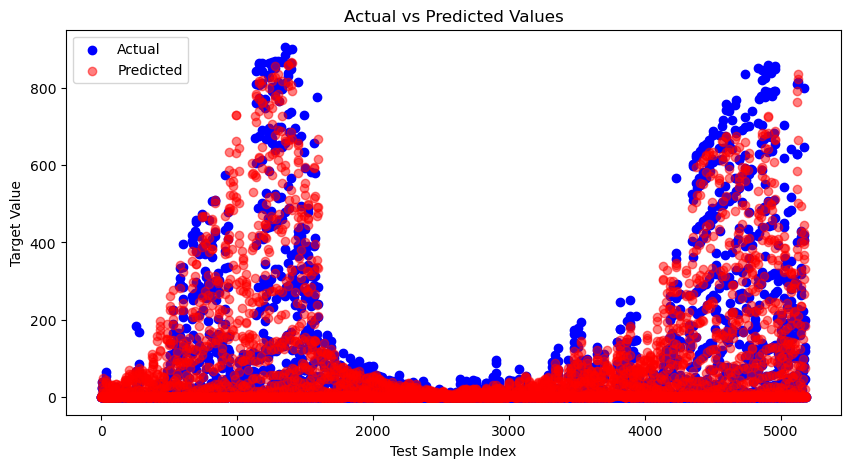

In [ ]:
# # Get predictions for the test set (already have y_test_B for actual values)
# y_pred_B_test = model_B.predict(X_test_B)

# plt.figure(figsize=(10,5))
# plt.scatter(range(len(y_test_B)), y_test_B, color='blue', label='Actual')
# plt.scatter(range(len(y_pred_B_test)), y_pred_B_test, color='red', label='Predicted', alpha=0.5)
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Test Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.show()




In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Split your dataset B into training and testing sets without shuffling
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=False)

# Define your parameter grid
best_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 550, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree'
}
# Initialize XGBRegressor with new best parameters
xgb = XGBRegressor(**best_params)
model_C = xgb.fit(X_C, y_C)
pred_C = model_C.predict(test_C)



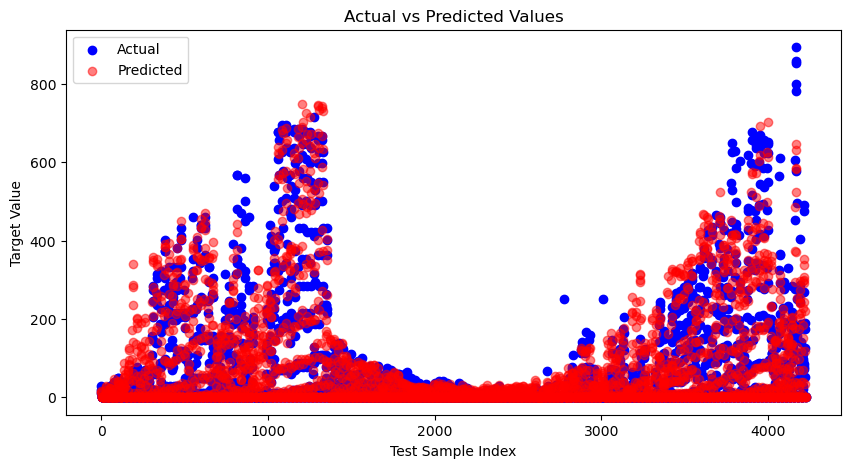

In [ ]:
# Get predictions for the test set (already have y_test_B for actual values)
y_pred_C_test = model_C.predict(X_test_C)

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_C)), y_test_C, color='blue', label='Actual')
plt.scatter(range(len(y_pred_C_test)), y_pred_C_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:


create_submission(pred_A,pred_B, pred_C, output_file="../../submission.csv")

Submission saved to ../../submission.csv


In [ ]:
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

X_A.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_A.columns]
# Assuming X_A and y_A are defined somewhere in your code
# Split the dataset into training and testing sets without shuffling
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)

# Parameters from XGBoost mapped to equivalent in LightGBM where necessary
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Define a parameter grid to search
param_dist = {
    'num_leaves': sp_randint(20, 200),  # Higher num_leaves can improve accuracy but may lead to overfitting
    'min_child_samples': sp_randint(5, 100),  # Minimum number of data in one leaf
    'min_child_weight': [0.001, 0.01, 0.1, 1, 10, 100],  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample': sp_uniform(loc=0.2, scale=0.8),  # Subsample ratio of the training instance
    'subsample_freq': sp_randint(0, 10),  # frequency of subsample, <=0 means no enable
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),  # Subsample ratio of columns when constructing each tree
    'reg_alpha': sp_uniform(0, 1),  # L1 regularization term on weights
    'reg_lambda': sp_uniform(0, 1),  # L2 regularization term on weights
    'scale_pos_weight': [1, 2, 6, 12],  # A value greater than 0 should be used in case of high class imbalance
    'learning_rate': sp_uniform(0.01, 0.3),  # Makes the model more robust by shrinking the weights on each step
    'n_estimators': sp_randint(100, 1000),  # Number of boosted trees to fit
    'max_depth': sp_randint(3, 10),  # Maximum tree depth for base learners
    'boosting_type': ['gbdt', 'dart', 'goss'],  # 'gbdt' stands for Gradient Boosting Decision Tree
}


# Run randomized search
n_iter_search = 10  # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(estimator=LGBMRegressor(), 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   cv=3, 
                                   scoring='neg_mean_absolute_error',
                                   verbose=10)


random_search.fit(X_train_A, y_train_A)

# Summarize results
print("Best parameters found: ", random_search.best_params_)
print("Lowest RMSE found: ", -random_search.best_score_)

# Use the best parameters to create a new model
best_lgb_model = LGBMRegressor(**random_search.best_params_)

# Re-fit the model based on the entire training data
best_lgb_model.fit(X_train_A, y_train_A)

# Predict and calculate MAE
lgb_pred_A = best_lgb_model.predict(X_test_A)
lgb_mae = mean_absolute_error(y_test_A, lgb_pred_A)
print(f'Mean Absolute Error for LightGBM: {lgb_mae}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START boosting_type=dart, colsample_bytree=0.4815386969317449, learning_rate=0.03200314584655852, max_depth=8, min_child_samples=74, min_child_weight=0.001, n_estimators=598, num_leaves=42, reg_alpha=0.857113761015935, reg_lambda=0.11686708334859308, scale_pos_weight=12, subsample=0.8589721148366027, subsample_freq=5
[CV 1/3; 1/10] END boosting_type=dart, colsample_bytree=0.4815386969317449, learning_rate=0.03200314584655852, max_depth=8, min_child_samples=74, min_child_weight=0.001, n_estimators=598, num_leaves=42, reg_alpha=0.857113761015935, reg_lambda=0.11686708334859308, scale_pos_weight=12, subsample=0.8589721148366027, subsample_freq=5;, score=-216.413 total time=  17.6s
[CV 2/3; 1/10] START boosting_type=dart, colsample_bytree=0.4815386969317449, learning_rate=0.03200314584655852, max_depth=8, min_child_samples=74, min_child_weight=0.001, n_estimators=598, num_leaves=42, reg_alpha=0.857113761015935, reg

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV 1/3; 5/10] END boosting_type=goss, colsample_bytree=0.6842988809540178, learning_rate=0.28638326471003245, max_depth=4, min_child_samples=25, min_child_weight=100, n_estimators=560, num_leaves=23, reg_alpha=0.036793517604155834, reg_lambda=0.8066452449073316, scale_pos_weight=2, subsample=0.7573449809346056, subsample_freq=9;, score=nan total time=   0.0s
[CV 2/3; 5/10] START boosting_type=goss, colsample_bytree=0.6842988809540178, learning_rate=0.28638326471003245, max_depth=4, min_child_samples=25, min_child_weight=100, n_estimators=560, num_leaves=23, reg_alpha=0.036793517604155834, reg_lambda=0.8066452449073316, scale_pos_weight=2, subsample=0.7573449809346056, subsample_freq=9
[CV 2/3; 5/10] END boosting_type=goss, colsample_bytree=0.6842988809540178, learning_rate=0.28638326471003245, max_depth=4, min_child_samples=25, min_child_weight=100, n_estimators=560, num_leaves=23, reg_alpha=0.036793517604155834, reg_lambda=0.8066452449073316, scale_pos_weight=2, subsample=0.757344980

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV 1/3; 6/10] END boosting_type=dart, colsample_bytree=0.9654132581725439, learning_rate=0.16969395450427258, max_depth=6, min_child_samples=46, min_child_weight=0.01, n_estimators=814, num_leaves=86, reg_alpha=0.9749125768101611, reg_lambda=0.06254176616864848, scale_pos_weight=2, subsample=0.38941805255557355, subsample_freq=3;, score=-223.111 total time=  23.8s
[CV 2/3; 6/10] START boosting_type=dart, colsample_bytree=0.9654132581725439, learning_rate=0.16969395450427258, max_depth=6, min_child_samples=46, min_child_weight=0.01, n_estimators=814, num_leaves=86, reg_alpha=0.9749125768101611, reg_lambda=0.06254176616864848, scale_pos_weight=2, subsample=0.38941805255557355, subsample_freq=3
[CV 2/3; 6/10] END boosting_type=dart, colsample_bytree=0.9654132581725439, learning_rate=0.16969395450427258, max_depth=6, min_child_samples=46, min_child_weight=0.01, n_estimators=814, num_leaves=86, reg_alpha=0.9749125768101611, reg_lambda=0.06254176616864848, scale_pos_weight=2, subsample=0.38

/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/petterdalhaug/anaconda3/envs/TD

Best parameters found:  {'boosting_type': 'dart', 'colsample_bytree': 0.6803004615520729, 'learning_rate': 0.03499293509817382, 'max_depth': 9, 'min_child_samples': 32, 'min_child_weight': 10, 'n_estimators': 766, 'num_leaves': 190, 'reg_alpha': 0.13062008293317418, 'reg_lambda': 0.8765753051985264, 'scale_pos_weight': 2, 'subsample': 0.6371764488975993, 'subsample_freq': 6}
Lowest RMSE found:  210.58111014108258


KeyboardInterrupt: 

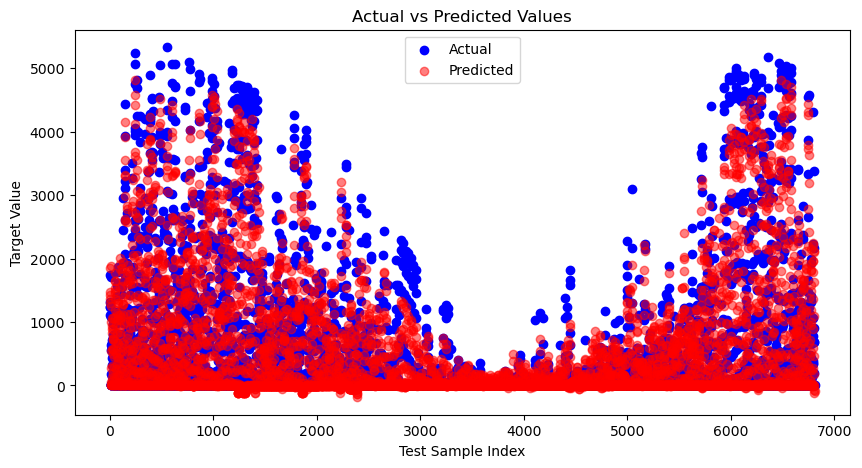

In [ ]:

y_pred_A_test = best_lgb_model.predict(X_test_A)

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()